# Lung Cancer Detection using Convolutional Neural Network (CNN)

## Introduction
This project aims to build a convolutional neural network (CNN) model to detect lung cancer using chest X-ray images.

## Dataset
The dataset used for this project is the Lung Nodule Analysis (LUNA) dataset. It contains chest X-ray images with labels indicating the presence of lung nodules.

## Preprocessing
Preprocessing steps include resizing images, normalizing pixel values, and augmenting data using techniques like rotation and flipping.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [5]:
from zipfile import ZipFile
 
data_path = 'lung-and-colon-cancer-histopathological-images.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [6]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

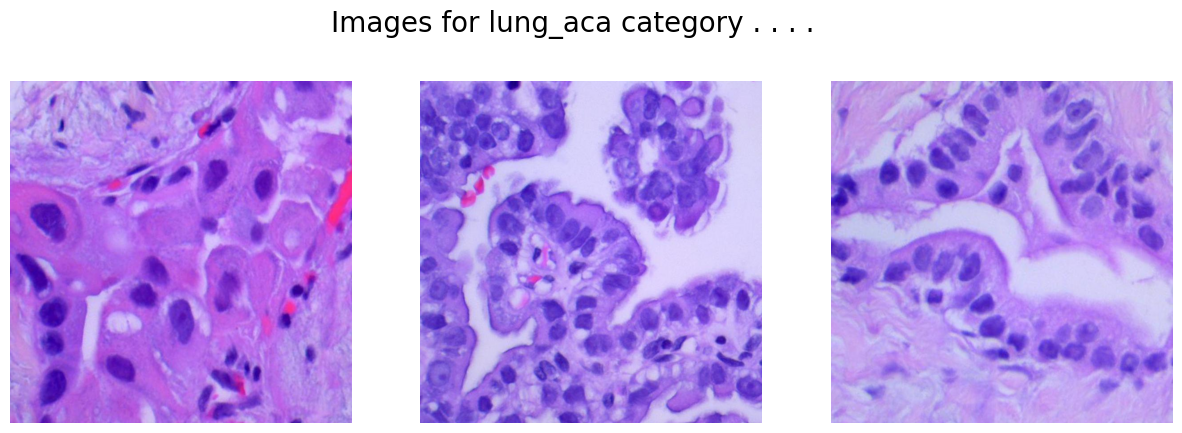

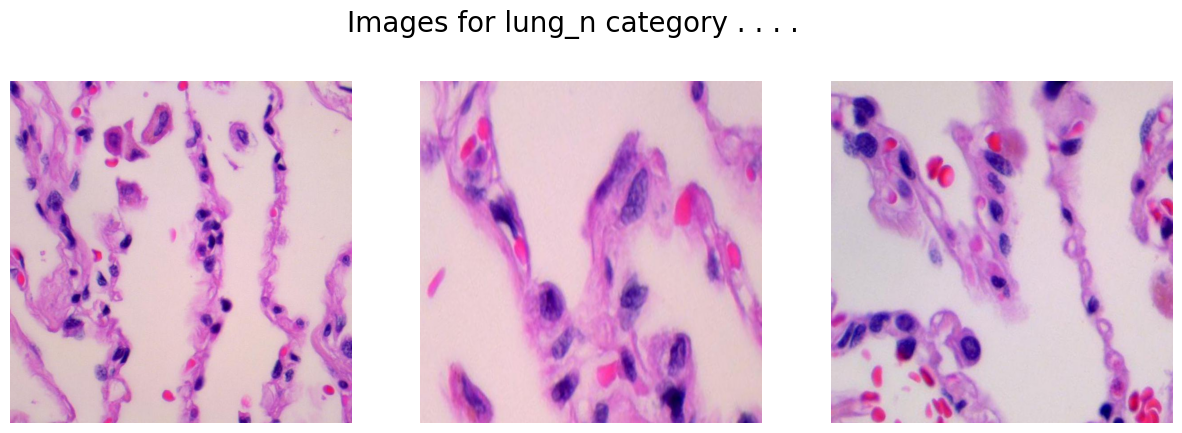

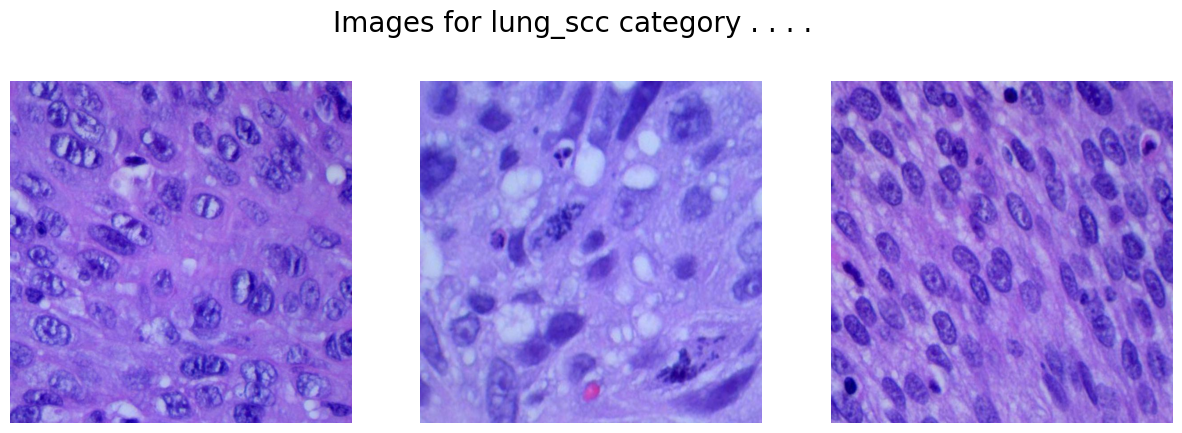

In [7]:
import os
from zipfile import ZipFile

extracted_path = 'lung_colon_image_set'
# Verify the path
base_path = os.path.join(extracted_path, 'lung_image_sets')
classes = ['lung_aca', 'lung_n', 'lung_scc']

for cat in classes:
    image_dir = os.path.join(base_path, cat)
    
    if not os.path.exists(image_dir):
        print(f"The directory {image_dir} does not exist.")
        continue
    
    images = os.listdir(image_dir)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    
    for i in range(3):
        img_path = os.path.join(image_dir, images[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].axis('off')
    
    plt.show()


In [8]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [10]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
        img = cv2.imread(image)

        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [12]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

In [22]:

keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [17]:

history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 576s 3s/step - loss: 0.3680 - accuracy: 0.8473 - val_loss: 3.4912 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 577s 3s/step - loss: 0.2133 - accuracy: 0.9136 - val_loss: 5.7268 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 558s 3s/step - loss: 0.1656 - accuracy: 0.9364 - val_loss: 2.3563 - val_accuracy: 0.6357 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 551s 3s/step - loss: 0.1353 - accuracy: 0.9491 - val_loss: 10.9332 - val_accuracy: 0.5697 - lr: 0.0010


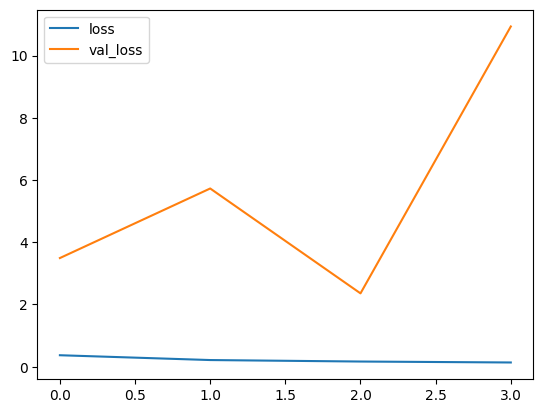

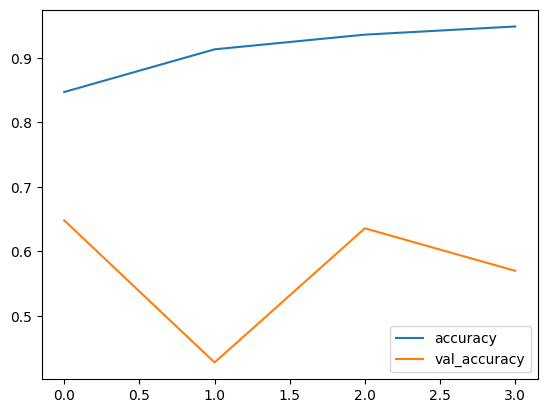

In [18]:

history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [19]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 21s 216ms/step


In [20]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[   0,   32,  955],
       [   0,  908,   69],
       [   0,    0, 1036]], dtype=int64)

In [21]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.00      0.00      0.00       987
      lung_n       0.97      0.93      0.95       977
    lung_scc       0.50      1.00      0.67      1036

    accuracy                           0.65      3000
   macro avg       0.49      0.64      0.54      3000
weighted avg       0.49      0.65      0.54      3000

